# Import_Library

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.applications import mobilenet_v2, ResNet50
from tensorflow import keras
import numpy as np
# import cv2
import uuid
import time
# import tensorflow_datasets as tfds
import pathlib
import warnings
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import imghdr

In [ ]:
# folder = '/tmp/valid_ind/Soto'
# for count, filename in enumerate(os.listdir(folder)):
#     dst = f"Soto{str(count)}.jpg"
#     src =f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
#     dst =f"{folder}/{dst}"
         
#     # rename() function will
#     # rename all the files
#     os.rename(src, dst)

In [ ]:
# !pip install tensorflow==2.6.0 --user

In [ ]:
# import imghdr
# # imghdr.what('/tmp/training_ind/food_datasets/')
# for dirpath, dirnames, filenames in os.walk('./tmp/training_ind/food_datasets/soto'):
#     for filename in filenames:
#         file_path = os.path.join(dirpath, filename)
#         if not imghdr.what(file_path, 'jpeg'):
#             print(file_path, ' is not an image')
#             os.remove(file_path)

In [2]:

# image_extensions = [".png", ".jpg"]  # add there all your images file extensions

# img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# for filepath in pathlib.Path('/tmp/valid_ind/').rglob("*"):
#     if filepath.suffix.lower() in image_extensions:
#         img_type = imghdr.what(filepath)
#         if img_type is None:
#             print(f"{filepath} is not an image, removing image")
#             os.remove(filepath)
#         elif img_type not in img_type_accepted_by_tf:
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow, removing image")
#             os.remove(filepath)

\tmp\valid_ind\Soto\00000008.jpg is not an image, removing image
\tmp\valid_ind\Soto\00000077.jpg is not an image, removing image
\tmp\valid_ind\Soto\00000088.jpg is not an image, removing image
\tmp\valid_ind\Soto\00000089.jpg is a webp, not accepted by TensorFlow, removing image
\tmp\valid_ind\Soto\00000090.jpg is not an image, removing image
\tmp\valid_ind\Soto\00000122.jpg is not an image, removing image
\tmp\valid_ind\Soto\00000141.jpg is not an image, removing image
\tmp\valid_ind\Soto\00000157.jpg is a webp, not accepted by TensorFlow, removing image
\tmp\valid_ind\Soto\00000163.jpg is not an image, removing image
\tmp\valid_ind\Soto\00000182.jpg is not an image, removing image
\tmp\valid_ind\Soto\Soto212.jpg is not an image, removing image


In [ ]:
# !pip install --upgrade pyqt5 lxml --user

In [ ]:
# LABELIMG_PATH = os.path.join('PROJECTS', 'labelimg')

In [ ]:
# if not os.path.exists(LABELIMG_PATH):
#     !mkdir {LABELIMG_PATH}
#     !git clone https://github.com/tzutalin/labelImg {LABELIMG_PATH}

In [ ]:
# if os.name == 'posix':
#     !make qt5py3
# if os.name =='nt':
#     !cd {LABELIMG_PATH} && pyrcc5 -o libs/resources.py resources.qrc

# Extracting and Getting The Image 

In [2]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Dataset Extracting (When Needed)
# test_local_zip = './DATASETS/Food_data/archive.zip'
# zip_ref = zipfile.ZipFile(test_local_zip, 'r')
# zip_ref.extractall('/tmp/training')
# zip_ref.close()

batch_size = 36
img_height = 128
img_width = 128

# training_datagen = ImageDataGenerator(
#       rescale = 1./255,
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest')

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/tmp/training_ind/food_datasets',
  # validation_split=0.2,
  # subset="training",
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/tmp/valid_ind/',
  # validation_split=0.2,
  # subset="validation",
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3815 files belonging to 4 classes.
Found 1721 files belonging to 4 classes.
['Bakso', 'Gado', 'Rendang', 'Sate']


# Visualize The Data

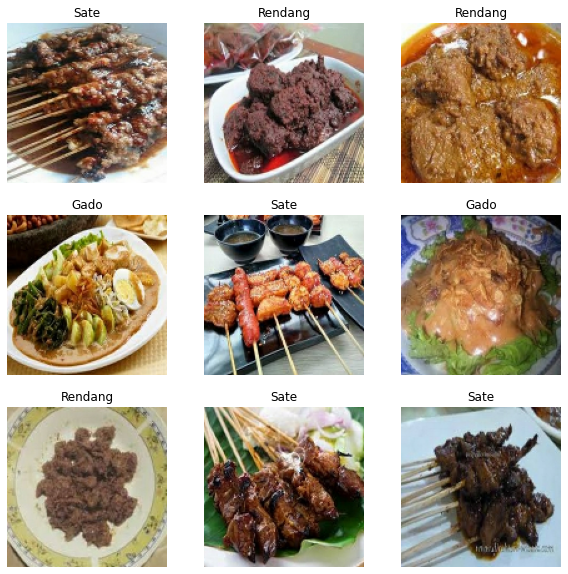

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Image Preprocessing


In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal_and_vertical'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomContrast(0.2,0.4))
    
    return data_augmentation

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5)
])                      

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
              train_ds,
              validation_data=val_ds,
              # steps_per_epoch = 10000 // 32,
              epochs = 100,
              verbose = 1
            )

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2,0.4)
  ]
)

In [34]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5,activation='softmax')

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              metrics=['accuracy'])
                                

In [46]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
history = model.fit(
              train_ds,
              validation_data=val_ds,
              # steps_per_epoch = 10000 // 32,
              epochs = 100,
              verbose = 1,
            )

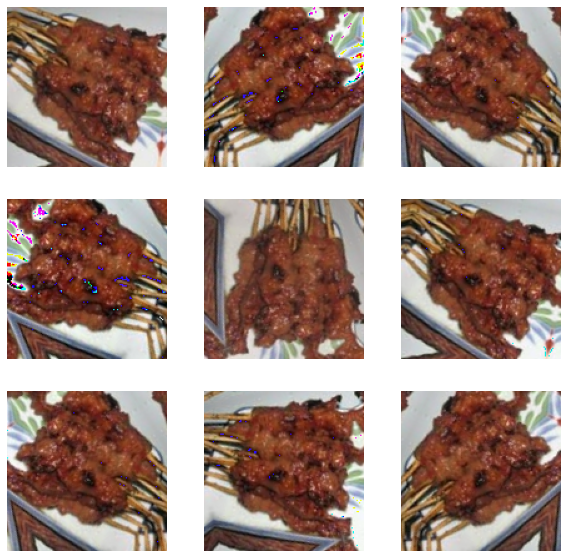

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [9]:
checkpoint = ModelCheckpoint(filepath='./tmp/checkpoint', monitor="val_accuracy", mode="max",save_best_only=True, save_weights_only=True)

In [27]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.91: # @KEEP
                print("\nReached 90% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True


In [28]:
# base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model = tf.keras.Sequential([
  # base_model,
  data_augmentation,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  layers.DepthwiseConv2D(kernel_size=3,padding='valid'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  layers.BatchNormalization(),
  # layers.DepthwiseConv2D(kernel_size=3,padding='same',strides=(1, 1)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4)
])

In [29]:
model.compile(#optimizer='adam',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
callbacks = [myCallback(),checkpoint]

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 64)       

In [31]:
history = model.fit(
              train_ds,
              validation_data=val_ds,
              # steps_per_epoch = 10000 // 32,
              epochs = 150,
              verbose = 1,
              callbacks=[callbacks]
            )



Epoch 1/150
106/106 [==============================] - 13s 106ms/step - loss: 2.1579 - accuracy: 0.5397 - val_loss: 1.2169 - val_accuracy: 0.4422
Epoch 2/150
106/106 [==============================] - 10s 96ms/step - loss: 0.8184 - accuracy: 0.6689 - val_loss: 0.9975 - val_accuracy: 0.5427
Epoch 3/150
106/106 [==============================] - 10s 98ms/step - loss: 0.7972 - accuracy: 0.6878 - val_loss: 0.7312 - val_accuracy: 0.7101
Epoch 4/150
106/106 [==============================] - 11s 100ms/step - loss: 0.6515 - accuracy: 0.7539 - val_loss: 0.6785 - val_accuracy: 0.7153
Epoch 5/150
106/106 [==============================] - 11s 100ms/step - loss: 0.6048 - accuracy: 0.7604 - val_loss: 2.0663 - val_accuracy: 0.4038
Epoch 6/150
106/106 [==============================] - 10s 98ms/step - loss: 0.5500 - accuracy: 0.7921 - val_loss: 1.2248 - val_accuracy: 0.5601
Epoch 7/150
106/106 [==============================] - 10s 97ms/step - loss: 0.4868 - accuracy: 0.8123 - val_loss: 0.9995 - val

In [42]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\e203a\AppData\Local\Temp\tmpixbnae03\assets


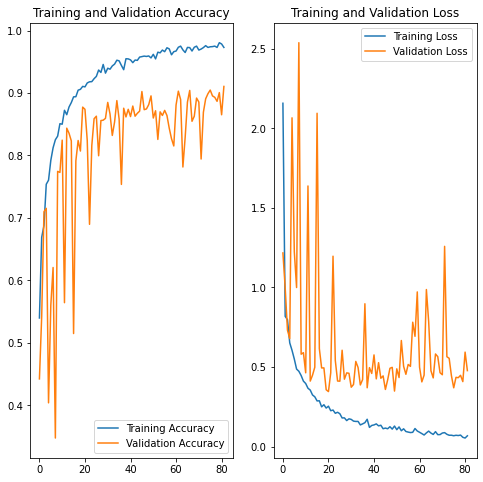

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(82)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# sunflower_url = "https://drive.google.com/file/d/1RzjRi4qUT_jOl9HJP6APYkBx0Ti9JhdA/view?usp=sharing"
# sunflower_path = tf.keras.utils.get_file('bakso_test', origin=sunflower_url)
# print(sunflower_path)

In [41]:
sunflower_path = '/tmp/test/download.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Bakso with a 100.00 percent confidence.


In [ ]:
#!/usr/bin/python
# path = '/tmp/images/apple_pie'
# dirs = os.listdir( path )

# def resize():
#     for item in dirs:
#         if os.path.isfile(path+item):
#             im = Image.open(path+item)
#             f, e = os.path.splitext(path+item)
#             imResize = im.resize((128,128), Image.ANTIALIAS)
#             imResize.save(f + ' resized.jpg', 'JPEG', quality=75)

# resize()

# import PIL
# import os
# import os.path
# from PIL import Image

# f = r'/tmp/images/waffles'
# for file in os.listdir(f):
#     f_img = f+"/"+file
#     img = Image.open(f_img)
#     img = img.resize((128,128))
#     img.save(f_img)